<a href="https://colab.research.google.com/github/databyhuseyn/DeepLearning/blob/main/Plant_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import zipfile

zip_ref = zipfile.ZipFile('/content/plant.zip')
zip_ref.extractall()
zip_ref.close()

In [10]:
import os
for (dirpath, dirnames, filenames) in os.walk('/content/plant'):
  print(f'There are {len(dirpath)} directories and {len(filenames)} images in {dirpath}')

There are 14 directories and 0 images in /content/plant
There are 20 directories and 0 images in /content/plant/Valid
There are 30 directories and 5 images in /content/plant/Valid/Black_rot
There are 32 directories and 5 images in /content/plant/Valid/Leaf_blight
There are 20 directories and 0 images in /content/plant/Train
There are 30 directories and 10 images in /content/plant/Train/Black_rot
There are 32 directories and 10 images in /content/plant/Train/Leaf_blight


In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/plant/Train/'
test_dir = '/content/plant/Valid/'

IMG_SIZE = (224, 224)
batch_size= 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(directory=train_dir,
                                          target_size = IMG_SIZE,
                                         # batch_size=batch_size,
                                          class_mode='categorical')
test = train_datagen.flow_from_directory(directory=test_dir,
                                          target_size = IMG_SIZE,
                                         # batch_size=batch_size,
                                          class_mode='categorical')

Found 20 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [49]:
import tensorflow as tf
import tensorflow_hub as hub

def create_model(model_url, num_classes = 10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = 'Feature_extraction_layer',
                                           input_shape = IMG_SIZE + (3, ))
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation='sigmoid', name = 'output_layer')
  ])

  return model

In [50]:
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [51]:
efficientnet_model = create_model(efficientnet_url, num_classes = test.num_classes)

In [52]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=optimizer,
                           metrics='accuracy')

In [53]:
efficientnet_model.fit(train,
                       epochs=5,
                       steps_per_epoch=len(train),
                       validation_data=test,
                       validation_steps=len(test))

Epoch 1/5
1/1 [==============================] - 16s 16s/step - loss: 0.5293 - accuracy: 0.9000 - val_loss: 0.4683 - val_accuracy: 1.0000
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 0.4552 - accuracy: 1.0000 - val_loss: 0.4174 - val_accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 0.3919 - accuracy: 1.0000 - val_loss: 0.3719 - val_accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 0.3372 - accuracy: 1.0000 - val_loss: 0.3315 - val_accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 2s 2s/step - loss: 0.2899 - accuracy: 1.0000 - val_loss: 0.2960 - val_accuracy: 1.0000


In [55]:
class_names = ['Black rot', 'Leaf blight']

In [73]:
def load_and_prep_image(filename, img_shape=224):
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  return img

In [77]:
def pred_and_plot(model, filename, class_names = class_names):
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[np.argmax(pred)]

  plt.imshow(img)
  plt.title(f'Prediction: {pred_class}')
  plt.axis(False)

In [61]:
!wget https://thedemogardenblog.files.wordpress.com/2009/06/june-9-0181.jpg

--2024-04-28 20:34:32--  https://thedemogardenblog.files.wordpress.com/2009/06/june-9-0181.jpg
Resolving thedemogardenblog.files.wordpress.com (thedemogardenblog.files.wordpress.com)... 192.0.72.21, 192.0.72.20
Connecting to thedemogardenblog.files.wordpress.com (thedemogardenblog.files.wordpress.com)|192.0.72.21|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://thedemogarden.org/wp-content/uploads/2009/06/june-9-0181.jpg [following]
--2024-04-28 20:34:32--  https://thedemogarden.org/wp-content/uploads/2009/06/june-9-0181.jpg
Resolving thedemogarden.org (thedemogarden.org)... 192.0.78.24, 192.0.78.25
Connecting to thedemogarden.org (thedemogarden.org)|192.0.78.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1444640 (1.4M) [image/jpeg]
Saving to: ‘june-9-0181.jpg’

june-9-0181.jpg     100%[===================>]   1.38M  8.89MB/s    in 0.2s    

2024-04-28 20:34:33 (8.89 MB/s) - ‘june-9-0181.jpg’ saved [1444640

In [62]:
pred_1 = '/content/june-9-0181.jpg'

1/1 [==============================] - 0s 79ms/step


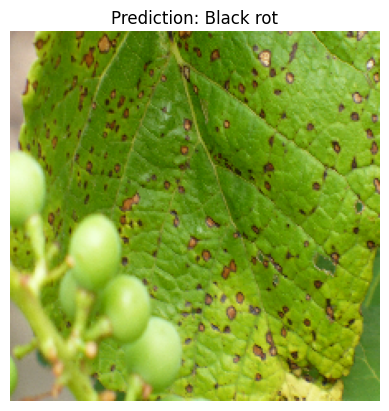

In [78]:
pred_and_plot(efficientnet_model, pred_1, class_names)